#   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> NLP Project: Text Classification (BBC)

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> loading libraries  

In [1]:
import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re #, string, unicodedata
#from   bs4 import BeautifulSoup

#from   textblob  import TextBlob, Word
from   wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import spacy

#from sklearn.svm           import SVC
#from sklearn.naive_bayes   import MultinomialNB
#from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model  import LogisticRegression, SGDClassifier
from sklearn               import model_selection, preprocessing, naive_bayes, ensemble 
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics       import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
import nltk   # pip install --upgrade nltk

nltk.download('punkt')
#from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize        import word_tokenize, sent_tokenize

nltk.download('stopwords') 
from nltk.corpus           import stopwords

nltk.download('wordnet')
from nltk.stem             import WordNetLemmatizer 

#from nltk.stem            import LancasterStemmer 
#from nltk.stem.porter     import PorterStemmer

[nltk_data] Downloading package punkt to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> loading dataset

In [3]:
data = pd.read_csv('bbcText.csv',delimiter=',')
data.head(1)

,category,text
0,tech,tv future in the hands of viewers w...


In [4]:
data = data.rename( columns={'category':'label'} )
data = data[ ['text','label'] ]
data.head()

,text,label
0,tv future in the hands of viewers w...,tech
1,123 worldcom boss left books alone for...,business
2,tigers wary of farrell gamble leicester say ...,sport
3,yeading face newcastle in fa cup premiership s...,sport
4,ocean s twelve raids box office ocean s twelve...,entertainment


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> EDA

In [5]:
data.shape

(2225, 2)

In [6]:
# removing duplicates
print('Before Treatment:  n duplicates =', sum(data.duplicated())) 
if sum( data.duplicated() ) > 0:
    data = data.drop_duplicates()
    data.index = range( data.shape[0] )
print('After Treatment:   n duplicates =', sum(data.duplicated())) 

Before Treatment:  n duplicates = 99
After Treatment:   n duplicates = 0


In [7]:
# removing null
data = data.dropna()
data.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
data.describe()

,text,label
count,2126,2126
unique,2126,5
top,tv future in the hands of viewers w...,sport
freq,1,504


In [9]:
data['label'].value_counts()

label
sport            504
business         503
politics         403
entertainment    369
tech             347
Name: count, dtype: int64

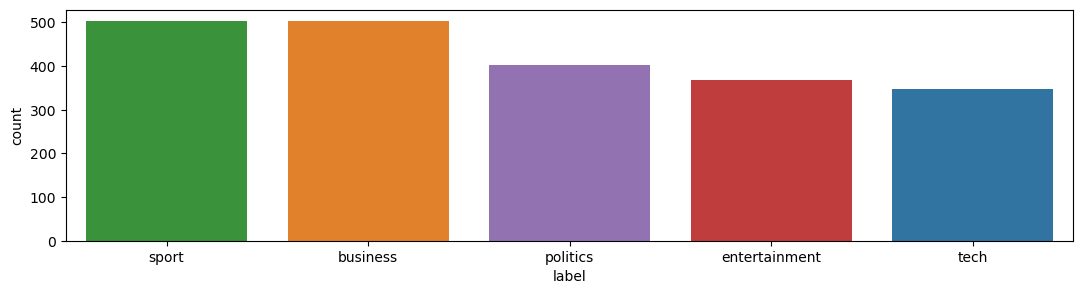

In [10]:
fig, ax = plt.subplots(figsize=(13,3))
sns.countplot( data=data, x='label', ax=ax, hue='label', order=data['label'].value_counts().index )
plt.show()

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> NLP Preprocessing

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Remove New Lines

In [11]:
# removing new lines
def remove_new_lines(text): return re.sub('[\n]',' ', text)
data['text'] = data['text'].apply(remove_new_lines)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Remove Punctuations

In [12]:
# removing punctuations
def remove_punctuations(text): return re.sub('[^a-zA-Z]',' ', text)
data['text'] = data['text'].apply(remove_punctuations)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Converting to LowerCase

In [13]:
# converting text to lower_case
def into_lower(text): return text.lower()
data['text'] = data['text'].apply(into_lower)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Set & Remove Stop_Words

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Setting Stop_Words

In [14]:
# Setting English StopWords
stop_words = set( stopwords.words('english') )
new_words  = [ 'some','one','like' ,'br', 'could','would','get','make','really','see',
               'well','much','good','great','first','last','people','also','bad','worst' ,'may','thing',
               'make','go','think','know','watch','look','many','said','say','mr','new','take','told','back' 
               'mr', 'mrs', 'upon', 'sir', 'yes', 'no', 'u', 's', 'k', 'next', 'half', 'quarter', 'third', 'late',
               'ago', 'before', 'after', 'behind', 'back', 'front', 'oh', 'yet'
             ] 
stop_words = stop_words.union(new_words)

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Removing Stop_Words

In [15]:
def remove_stop_words(text):
    Clean = []
    for word in text.split():
        if word not in stop_words:
            Clean.append(word) 
    return ' '.join( Clean )

data['text'] = data['text'].apply( remove_stop_words )
data.head()

,text,label
0,tv future hands viewers home theatre systems p...,tech
1,worldcom boss left books alone former worldcom...,business
2,tigers wary farrell gamble leicester rushed ma...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raids box office ocean twelve cri...,entertainment


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Lemmatizing

In [16]:
# Lemmatizing 
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    Clean = []
    for word in text.split():
        Clean.append( lemmatizer.lemmatize(word) )
    return ' '.join( Clean )

data['text'] = data['text'].apply(lemmatize_text)
data.head()

,text,label
0,tv future hand viewer home theatre system plas...,tech
1,worldcom bos left book alone former worldcom b...,business
2,tiger wary farrell gamble leicester rushed mak...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raid box office ocean twelve crim...,entertainment


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Stemming
 - Faster but less accurate than Lemmatizer

In [17]:
# Stemming
''' 
Stemmer = PorterStemmer()

def stem_text(text):
    Clean = []
    for word in text.split():
        Clean.append( Stemmer.stem(word) )
    return ' '.join( Clean )

data['text'] = data['text'].apply(stem_text)
data.head()
''' 
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Removing Stop_Words

In [18]:
def remove_stop_words(text):
    Clean = []
    for word in text.split():
        if word not in stop_words:
            Clean.append(word) 
    return ' '.join( Clean )

data['text'] = data['text'].apply( remove_stop_words )
data.head()

,text,label
0,tv future hand viewer home theatre system plas...,tech
1,worldcom bos left book alone former worldcom b...,business
2,tiger wary farrell gamble leicester rushed mak...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raid box office ocean twelve crim...,entertainment


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Bag of Words (List)

In [19]:
def bag_of_words_maker(df,ft):
    texts = df[ft]
    bag   = []
    for text in texts:
        for word in text.split():
            bag.append( word )
    return bag

bag_of_words = bag_of_words_maker( data, 'text' )
bag_of_words[:5]

['tv', 'future', 'hand', 'viewer', 'home']

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Bag of Words (DataFrame)

In [20]:
bag_of_words = pd.DataFrame( bag_of_words, columns=['word'] )
bag_of_words.head(3)

,word
0,tv
1,future
2,hand


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Words Count (DataFrame)

In [21]:
words_count         = pd.DataFrame( bag_of_words[ 'word' ].value_counts() )
words_count['word'] = words_count.index
words_count.index   = range( words_count.shape[0] )
words_count.head(5)

,count,word
0,3193,year
1,1569,time
2,1452,game
3,1235,two
4,1186,world


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Visualizing Top Words

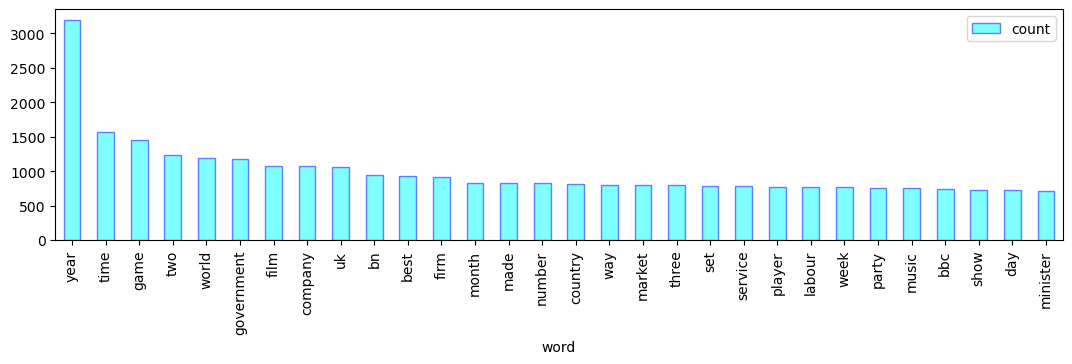

In [22]:
df = words_count
cat, sclr = 'word', 'count'

df.groupby(by=[cat])[sclr].median().reset_index().sort_values([sclr],ascending=False).head(30).\
plot( x=cat, y=sclr, kind='bar',  figsize=(13,3), color='cyan', edgecolor='blue', alpha=0.5 ); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Keeping Top Words

In [23]:
n = 500
Top_Words = words_count.loc[:n,'word'].tolist()
Top_Words[:15]

['year',
 'time',
 'game',
 'two',
 'world',
 'government',
 'film',
 'company',
 'uk',
 'bn',
 'best',
 'firm',
 'month',
 'made',
 'number']

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Text Reduction

In [24]:
def text_reduct( text ):
    Clean = []
    for word in text.split():
        if word in Top_Words:
            Clean.append(word)
    return ' '.join(Clean)

data['text'] = data['text'].apply(text_reduct)
data.head()

,text,label
0,tv future hand home system high tv digital vid...,tech
1,left book former bn bn never made decision dav...,business
2,making bid britain rugby league still way away...,sport
3,face cup side united face league leader cup ga...,sport
4,office number office chart took sale according...,entertainment


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Cool Image of Top Phrases

In [25]:
vec=CountVectorizer( min_df=0, max_df=500, binary=False, ngram_range=(2,3) ).fit(data['text'])
bag=vec.transform(data['text'])

s = bag.sum(axis=0)
f = [ (word,s[0,idx]) for word, idx in vec.vocabulary_.items() ]
f = sorted( f, key=lambda x: x[1], reverse=True )
f[:5]

[('year old', 338),
 ('prime minister', 304),
 ('bn bn', 213),
 ('chief executive', 200),
 ('tony blair', 176)]

In [26]:
Top_N = 30
Top_Phrases = pd.DataFrame(f[:Top_N], columns=['Word','Freq'])
Top_Phrases.head()

,Word,Freq
0,year old,338
1,prime minister,304
2,bn bn,213
3,chief executive,200
4,tony blair,176


In [27]:
Top_Corpus = []
for w in Top_Phrases['Word']:
    try:
        w1,w2 = w.split()
        Top_Corpus.append(str(w1+'_'+w2))
    except:
        try:
            w1,w2,w3 = w.split()
            Top_Corpus.append(str(w1+'_'+w2+'_'+w3))
        except:
            w1,w2,w3,w4 = w.split()
            Top_Corpus.append(str(w1+'_'+w2+'_'+w3+'_'+w4))
Top_Corpus = ' '.join(Top_Corpus)
Top_Corpus

'year_old prime_minister bn_bn chief_executive tony_blair mobile_phone bbc_news general_election six_nation two_year michael_howard human_right five_year bbc_radio interest_rate home_secretary three_year three_month world_cup long_term news_website bbc_news_website stock_market economic_growth labour_party tory_leader champion_league four_year public_service election_campaign'

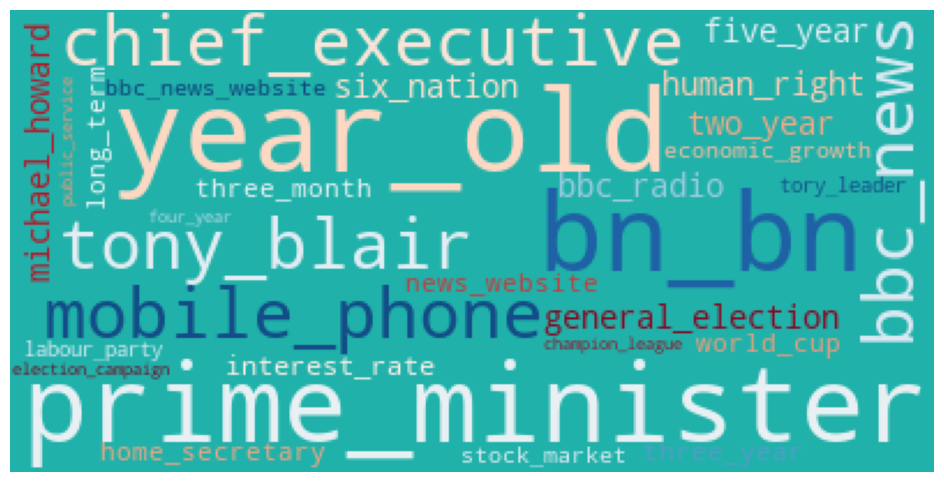

In [28]:
wordcloud = WordCloud( 
    
    background_color='LightSeaGreen', colormap='RdBu',
    #background_color='black', colormap='Greens',
    #background_color='black', colormap='Blues',
    
    stopwords        = stop_words,
    max_words        = Top_N,
    max_font_size    = 50,
    random_state     = 7 
    ).generate( str(Top_Corpus) ) 

fig = plt.figure(figsize=(13,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Train-Valid-Test Split (Text)

In [29]:
n  = data.shape[0]

Train_Text  = data.text[           :int(.8*n) ]
Valid_Text  = data.text[  int(.8*n):int(.9*n) ]
Test_Text   = data.text[  int(.9*n):          ]

Train_Label = data.label[          :int(.8*n) ]
Valid_Label = data.label[ int(.8*n):int(.9*n) ]
Test_Label  = data.label[ int(.9*n):          ]

In [30]:
Valid_Text[:3]

1700    charge chelsea face football action comment ma...
1701    mobile industry set number high device movie m...
1702    injury england despite six nation year old rig...
Name: text, dtype: object

In [31]:
Valid_Label[:3]

1700    sport
1701     tech
1702    sport
Name: label, dtype: object

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Count Vectorizer

In [32]:
# Count vectorizer for bag of words
cv=CountVectorizer( min_df=0, max_df=500, binary=False, ngram_range=(1,3) )

In [33]:
# transformed Data
CV_Train = cv.fit_transform( Train_Text )
CV_Valid = cv.transform(     Valid_Text )
CV_Test  = cv.transform(     Test_Text  )

In [34]:
print('BOW CV_Train:', CV_Train.shape)
print('BOW CV_Valid:', CV_Valid.shape)
print('BOW CV_Test: ', CV_Test.shape )

BOW CV_Train: (1700, 199381)
BOW CV_Valid: (213, 199381)
BOW CV_Test:  (213, 199381)


In [35]:
Train_Text

0       tv future hand home system high tv digital vid...
1       left book former bn bn never made decision dav...
2       making bid britain rugby league still way away...
3       face cup side united face league leader cup ga...
4       office number office chart took sale according...
                              ...                        
1695    india bn deal bn deal india low cost market se...
1696    share group news london line sale debt company...
1697    way side got european football cup win playing...
1698    england former david england ireland england c...
1699    mp official two wale mp common public account ...
Name: text, Length: 1700, dtype: object

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> TF-IDF Vectorizer

In [36]:
# TF-IDF vectorizer for bag of words
tf = TfidfVectorizer( min_df=0, max_df=500, use_idf=True, ngram_range=(1,3) )

In [37]:
# transformed Data
TF_Train = tf.fit_transform( Train_Text )
TF_Valid = tf.transform(     Valid_Text )
TF_Test  = tf.transform(     Test_Text  )

In [38]:
print('BOW TF_Train:', TF_Train.shape)
print('BOW TF_Valid:', TF_Valid.shape)
print('BOW TF_Test: ', TF_Test.shape )

BOW TF_Train: (1700, 199381)
BOW TF_Valid: (213, 199381)
BOW TF_Test:  (213, 199381)


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Logistic Regression Model

In [39]:
model = LogisticRegression( penalty='l2', max_iter=500, C=1, random_state=7 )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Model with Count Vectorizer

In [40]:
# Fitting
CV_Model = model.fit( CV_Train, Train_Label )
print(CV_Model)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


LogisticRegression(C=1, max_iter=500, random_state=7)


In [41]:
# Predicting
CV_Pred = CV_Model.predict( CV_Valid )
CV_Pred

array(['sport', 'tech', 'sport', 'tech', 'sport', 'sport', 'business',
       'business', 'tech', 'sport', 'business', 'tech', 'politics',
       'sport', 'business', 'entertainment', 'entertainment', 'tech',
       'politics', 'sport', 'sport', 'business', 'tech', 'entertainment',
       'entertainment', 'politics', 'politics', 'business', 'sport',
       'entertainment', 'entertainment', 'business', 'sport', 'politics',
       'business', 'sport', 'entertainment', 'tech', 'politics',
       'politics', 'sport', 'sport', 'politics', 'business', 'business',
       'business', 'business', 'entertainment', 'business', 'politics',
       'politics', 'tech', 'tech', 'entertainment', 'politics',
       'entertainment', 'business', 'politics', 'sport', 'sport',
       'business', 'tech', 'business', 'sport', 'business', 'business',
       'politics', 'sport', 'sport', 'politics', 'politics',
       'entertainment', 'entertainment', 'politics', 'business',
       'politics', 'politics', 'busi

In [42]:
# Scoring (Accuracy)  
CV_Score = accuracy_score( CV_Pred, Valid_Label )
print("CV_Score :",CV_Score)

CV_Score : 0.9671361502347418


C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Model with TF-IDF Vectorizer

In [43]:
# Fitting
TF_Model = model.fit( TF_Train, Train_Label )
print(TF_Model)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


LogisticRegression(C=1, max_iter=500, random_state=7)


In [44]:
# Predicting
TF_Pred = TF_Model.predict( TF_Valid )
TF_Pred

array(['sport', 'tech', 'sport', 'tech', 'sport', 'sport', 'politics',
       'business', 'tech', 'sport', 'business', 'tech', 'politics',
       'sport', 'business', 'entertainment', 'entertainment', 'tech',
       'politics', 'sport', 'sport', 'business', 'tech', 'entertainment',
       'entertainment', 'politics', 'politics', 'business', 'sport',
       'entertainment', 'entertainment', 'business', 'sport', 'politics',
       'business', 'sport', 'entertainment', 'tech', 'politics',
       'politics', 'sport', 'sport', 'politics', 'business', 'business',
       'business', 'business', 'entertainment', 'business', 'politics',
       'politics', 'tech', 'tech', 'entertainment', 'politics',
       'entertainment', 'business', 'politics', 'sport', 'sport',
       'business', 'tech', 'business', 'sport', 'business', 'business',
       'politics', 'sport', 'sport', 'politics', 'politics',
       'entertainment', 'entertainment', 'politics', 'business',
       'politics', 'politics', 'busi

In [45]:
# Scoring (Accuracy)  
TF_Score = accuracy_score( TF_Pred, Valid_Label )
print("TF_Score :",TF_Score)

TF_Score : 0.971830985915493


C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


#####   

#####   